# Micrograd

Auto-gradient engine that implements backpropagation over a dynamically built DAG and a small neural networks library on top, like Pytorch. Only operates over scalar values.

Remember backprop from cs189. uses chain rule to work backwards from expression.e.g. how a and b are affecting g through expression.

## Neural Network

Input = data and weights of neural network + math expression + output prediction or loss function

Backprop is about arbitrary expressions, used to train neural networks

To train larger values, we use tensors, arrays of scalars, allows us to take advanatage of parallelism, but none of the math changes.

## Working with Derivatives

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
  return 3 * x ** 2 - 4 * x + 5

In [ ]:
f(3.0)

20.0

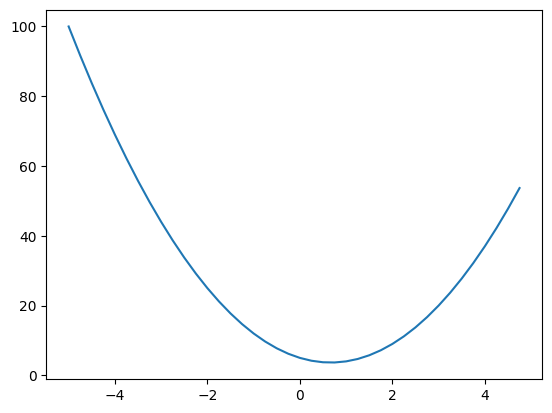

In [ ]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [ ]:
# More complex --> if I want the derivative of d wrt a, b, c, requires chain rule
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
d

4.0

# Class Definitions

In [164]:
from re import S
class Value:

  def __init__(self, data, _children=(), _op = '', label = ''):
    #value, which numbers were its children, and what operations
    #maintain the gradient with respect to the end
    self.data = data
    #function to change output gradient into input gradient, default for nothing
    self._backward = lambda: None
    self._prev = set(_children)  #for efficiency
    self._op = _op
    self.label = label

    #backprop
    self.grad = 0.0


  def __repr__(self):
    return f"Value(data={self.data}"

  def __radd__(self, other):
    return self + other

  def __add__(self, other):
    # feed in children
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    #propogate backward, out.grad into self and other
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):    #a * 2 works, but 2 * a doesnt
    return self * other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    #propogate backward, out.grad into self and other
    def _backward():
      #accumulate grads
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __sub__(self, other):
    return self + (-1 * other)

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/floats"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * self.data **(other-1) * out.grad

    out._backward = _backward
    return out

  def __truediv__(self, other):
    return self * other**-1

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    def _backward():
      self.grad = out.data * out.grad #math.exp(x) is the derivative
    out._backward = _backward
    return out

  def tanh(self):
    val = self.data
    exp = (math.exp(2 * val) - 1) / (math.exp(2 * val) + 1)
    out = Value(exp, (self, ), 'tanh' )

    def _backward(): #(tanh)
      self.grad = (1 - exp**2) * out.grad

    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


a = Value(2.0,label='a')
b = Value(3.0, label='b')
c = Value(4.0,label='c')
e = a + b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f
L.label = 'L'


In [105]:
# Visualize expression graphs
from graphviz import Digraph

#perform dfs from the graph to keep track of all the nodes and its edges
def trace(root):
  visited, edges = set(), set()
  def build(v):
    if v not in visited:
      visited.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return visited, edges

# draw the visualization
def draw_dot(root):
  visited, edges = trace(root)
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  for n in visited:
    dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape= 'record')
    if n._op:
      dot.node(name =str(id(n)) + n._op, label = n._op)
      dot.edge(str(id(n)) + n._op, str(id(n)))

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

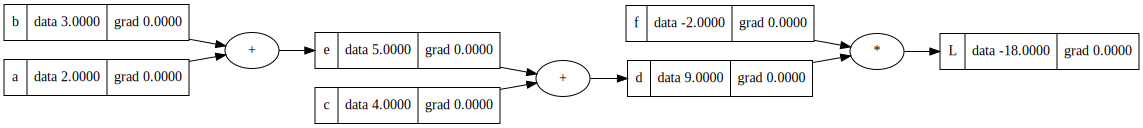

In [106]:
draw_dot(L)

# Backpropagation
For each value, computing the derivative of that node with respect to the end (L) which is the loss function with respect to the weights of the neural network

Each operation knows the local derivatives (d = c + e, so dd/dc = 1 and dd/de = 1), but we want dL/dc.

We can represent this idea with a graph using chain rule, e.g. dL/dc = dL/dd * dd/dc. with each node, we know how the inputs influence the derivative at this step.

## Neuron Example
2 neurons, activation function applied to weights * inputs + biases

In [110]:
#inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
#bias
b = Value(6.8813735870195432, label = 'b')

#dot products
x1w1 = x1 * w1
x1w1.label = 'x1w1'
x2w2 = x2 * w2
x2w2.label = 'x2w2'
#add together
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1 + x2w2'

#add bias
n = x1w1x2w2 + b
n.label = 'n'

#apply activation function
#--------------#
e = (2*n).exp()
o = (e-1)/(e+1)

#--------------#
#o = n.tanh()
o.label = 'o'


In [111]:
o.backward()

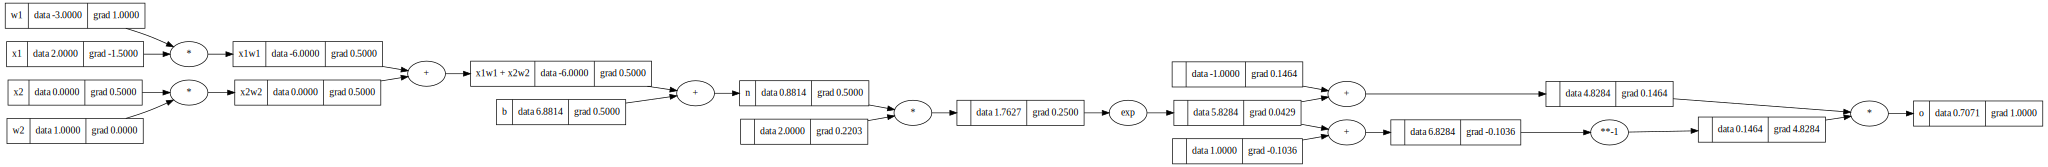

In [112]:
#plot n
draw_dot(o)

do/x1 = do/dn * dn/dx1w1x2w2 * dx1w1x2w2/dx1w1 * dx1w1/dx1

## Doing the same in Pytorch

In [113]:
import torch

#scalar value tensors
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True

x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True

w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True

n = w1*x1 + w2*x2 + b
o = torch.tanh(n)

print(o.data.item())

o.backward()

print("_____")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
_____
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


# Building Neural Network

In [256]:
import random
class Neuron:
  def __init__(self, min):
    self.w = [Value(random.uniform(-1,1)) for _ in range(min)]
    self.b = Value(random.uniform(-1,1))

  # as if applying function to x
  def __call__(self, x):
    #w * x + b
    #pairwise multiplication
    act = sum((wi * xi for wi, xi, in zip(self.w, x)), self.b)
    #activation function
    out = act.tanh()
    return out

  #like pytorch, returns parameters
  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

n = MLP(3, [4,4,1])

In [179]:
len(n.parameters())

41

In [257]:
#example dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]     #binary targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.5384276717489813,
 Value(data=0.4792989461973716,
 Value(data=0.5410585746457208,
 Value(data=0.5640587628650037]

In [252]:
#loss = single number that measures the total performance of the neural net
#example: mean squared error
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.04876029437683809

In [249]:
loss.backward()

In [ ]:
draw_dot(loss)

## Training Steps
gradient descent: vector point in direction of increased loss

if gradient is positive, influence on loss is positive, so increasing weight will increase loss and vice-versa, so we want to go in the opposite direction

In [250]:
for p in n.parameters():
  #gradient descent: lr * grad
  #lr is a subtle art of choosing
  p.data += -.01 * p.grad

In [260]:
#training loop
epochs = 50
for epoch in range(epochs):
  #forward pass
  ypred = [n(x) for x in xs]

  #evaluate loss
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  #backward pass
  #zero_grad
  for p in n.parameters():
    p.grad = 0
  loss.backward()

  #update
  for p in n.parameters():
    p.data += -.01 * p.grad

  print(epoch, loss.data)


0 0.040025908880186443
1 0.039539351921478595
2 0.03906387685704153
3 0.03859911847260876
4 0.03814472718659683
5 0.03770036823146759
6 0.03726572088557609
7 0.036840477751935836
8 0.036424344080612195
9 0.036017037131716154
10 0.035618285576207824
11 0.03522782893193351
12 0.034845417032517395
13 0.034470809526912755
14 0.03410377540757853
15 0.0337440925654019
16 0.03339154736962621
17 0.033045934271169954
18 0.032707055427840276
19 0.032374720350054426
20 0.032048745565777574
21 0.031728954303480605
22 0.031415176192003964
23 0.031107246976291063
24 0.03080500824802674
25 0.030508307190282635
26 0.030216996335331713
27 0.02993093333485116
28 0.02964998074178482
29 0.02937400580318473
30 0.029102880263396462
31 0.028836480176993737
32 0.028574685730906994
33 0.028317381075225894
34 0.028064454162189174
35 0.027815796592905586
36 0.027571303471379517
37 0.02733087326543937
38 0.02709440767419413
39 0.026861811501665073
40 0.026632992536260412
41 0.026407861435783837
42 0.0261863316176